In [1]:
import demo_util
import numpy as np
import torch
from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download
from modeling.maskgit import ImageBert
from modeling.titok import TiTok

/home/qiyuan/jtrain_from_titok/modeling/modules/losses.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/qiyuan/jtrain_from_titok/modeling/quantizer/quantizer.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/qiyuan/jtrain_from_titok/modeling/quantizer/quantizer.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/qiyuan/jtrain_from_titok/modeling/quantizer/quantizer.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled=False)
/home/qiyuan/jtrain_from_titok/modeling/quantizer/quantizer.py:123: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Pl

attention mode is flash


In [2]:
# load the pretrained models from huggingface
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
# titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
# titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")

# or alternatively, downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

In [2]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [40]:
config = demo_util.get_config("configs/infer/titok_l32.yaml")
config = demo_util.get_config("configs/infer/titok_b64.yaml")

In [41]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'tokenizer_titok_b64.bin', 'generator_checkpoint': 'generator_titok_b64.bin', 'output_dir': 'titok_b_64'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'base', 'vit_dec_model_size': 'base', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 64, 'finetune_decoder': True}, 'generator': {'model_type': 'ViT', 'hidden_size': 768, 'num_hidden_layers': 24, 'num_attention_heads': 16, 'intermediate_size': 3072, 'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 8, 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000, 'randomize_temperature': 11.0, 'guidance_scale': 3.0, 'guidance_decay': 'linear'}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [42]:
# supported tokenizer: [tokenizer_titok_l32_imagenet, tokenizer_titok_b64_imagenet, tokenizer_titok_s128_imagenet]
# titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_l32_imagenet")
titok_tokenizer = TiTok.from_pretrained("yucornetto/tokenizer_titok_b64_imagenet")
titok_tokenizer.eval()
titok_tokenizer.requires_grad_(False)
# or alternatively, downloads from hf

# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# titok_tokenizer = demo_util.get_titok_tokenizer(config)

print(titok_tokenizer)

TiTok(
  (encoder): TiTokEncoder(
    (patch_embed): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (conv_out): Conv2d(768, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): TiTokDecoder(
    (decoder_embed): Linear(in_features=12, out_features=7

In [ ]:
# # supported generator: [generator_titok_l32_imagenet, generator_titok_b64_imagenet, generator_titok_s128_imagenet]
# titok_generator = ImageBert.from_pretrained("yucornetto/generator_titok_l32_imagenet")
# titok_generator.eval()
# titok_generator.requires_grad_(False)

# # or alternatively, downloads from hf
# # hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")
# # titok_generator = demo_util.get_titok_generator(config)
# print(titok_generator)

ImageBert(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(5098, 768)
      (position_embeddings): Embedding(33, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

In [44]:
device = "cuda"

In [43]:
titok_tokenizer = titok_tokenizer.to(device)
# titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [45]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path, drop_rate=0.0, mask="zero"):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    print("Token Shape:", encoded_tokens.shape)
    
    # # Randomly selection
    # indices = torch.randperm(32)[:32]
    # encoded_tokens = encoded_tokens[..., indices]

    # Mask out later part
    print(titok_tokenizer.decoder.mask_token.shape)
    keep_tokens = int(encoded_tokens.shape[-1] * (1 - drop_rate)) - 1
    if mask == "zero":
        encoded_tokens[:, :, keep_tokens:] = torch.zeros_like(encoded_tokens[:, :, keep_tokens:])
    
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

torch.Size([1, 12, 1, 64])
Token Shape: torch.Size([1, 1, 64])
torch.Size([1, 1, 768])
Input Image is represented by codes tensor([[[1327, 3938, 1656, 3309, 2768, 3240, 1479, 1627, 3097, 3094, 2258,
           414, 1928, 1983,  977,  714, 3782, 2233, 3970, 2304,  892, 4054,
            77, 3502, 2994, 1533, 3651, 1605, 2865, 2828,  776, 1000, 3113,
          3755, 3000, 3571, 1123, 3075, 1436,  325, 3977, 3364, 2672, 1727,
          3506, 2034,  189, 3757,  329, 1228,  790, 3397,  964, 1358, 2820,
          2585, 1559, 3110, 1325, 1048,  266, 3316, 2852,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 64])
orginal image:


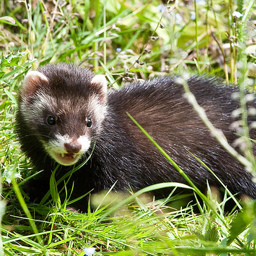

reconstructed image:


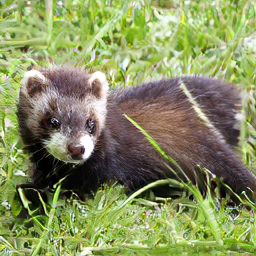

torch.Size([1, 12, 1, 64])
Token Shape: torch.Size([1, 1, 64])
torch.Size([1, 1, 768])
Input Image is represented by codes tensor([[[1327, 3938, 1656, 3309, 2768, 3240, 1479, 1627, 3097, 3094, 2258,
           414, 1928, 1983,  977,  714, 3782, 2233, 3970, 2304,  892, 4054,
            77, 3502, 2994, 1533, 3651, 1605, 2865, 2828,  776, 1000, 3113,
          3755, 3000, 3571, 1123, 3075, 1436,  325, 3977, 3364, 2672, 1727,
          3506, 2034,  189,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 64])
orginal image:


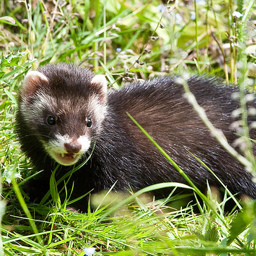

reconstructed image:


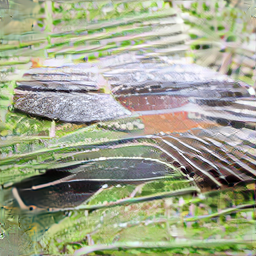

torch.Size([1, 12, 1, 64])
Token Shape: torch.Size([1, 1, 64])
torch.Size([1, 1, 768])
Input Image is represented by codes tensor([[[1327, 3938, 1656, 3309, 2768, 3240, 1479, 1627, 3097, 3094, 2258,
           414, 1928, 1983,  977,  714, 3782, 2233, 3970, 2304,  892, 4054,
            77, 3502, 2994, 1533, 3651, 1605, 2865, 2828,  776,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 64])
orginal image:


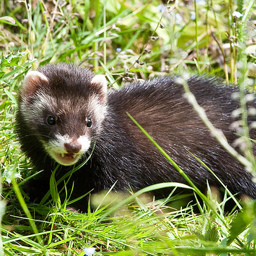

reconstructed image:


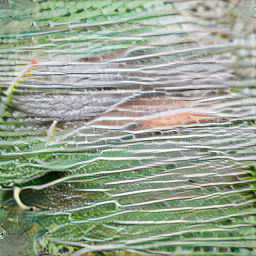

torch.Size([1, 12, 1, 64])
Token Shape: torch.Size([1, 1, 64])
torch.Size([1, 1, 768])
Input Image is represented by codes tensor([[[1327, 3938, 1656, 3309, 2768, 3240, 1479, 1627, 3097, 3094, 2258,
           414, 1928, 1983,  977,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 64])
orginal image:


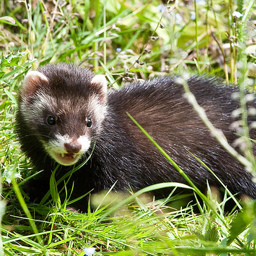

reconstructed image:


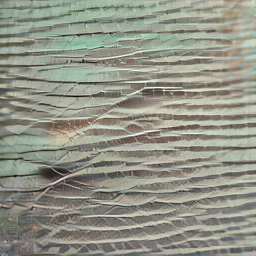

In [ ]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png", drop_rate=0.25)
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png", drop_rate=0.5)
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png", drop_rate=0.75)

torch.Size([1, 12, 1, 32])
Token Shape: torch.Size([1, 1, 32])
torch.Size([1, 1, 1024])
Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


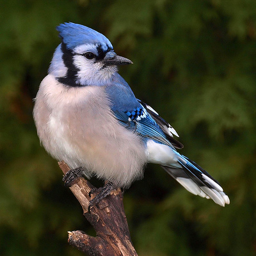

reconstructed image:


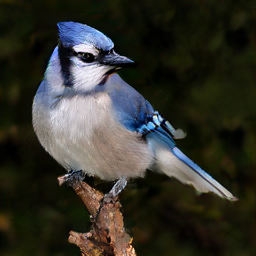

torch.Size([1, 12, 1, 32])
Token Shape: torch.Size([1, 1, 32])
torch.Size([1, 1, 1024])
Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056,    0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


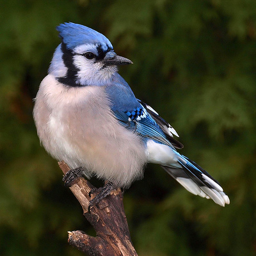

reconstructed image:


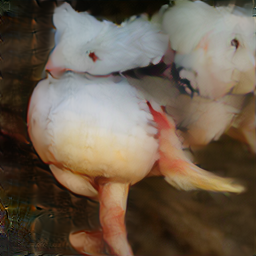

torch.Size([1, 12, 1, 32])
Token Shape: torch.Size([1, 1, 32])
torch.Size([1, 1, 1024])
Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


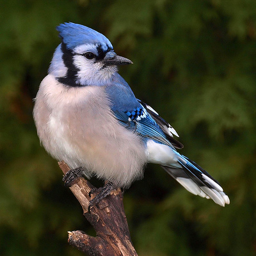

reconstructed image:


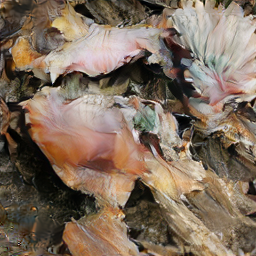

torch.Size([1, 12, 1, 32])
Token Shape: torch.Size([1, 1, 32])
torch.Size([1, 1, 1024])
Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


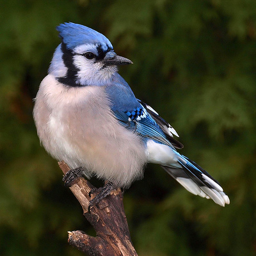

reconstructed image:


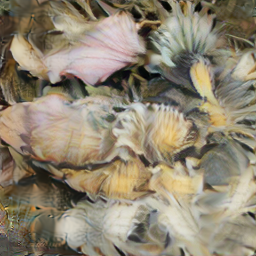

In [35]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png", drop_rate=0.25)
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png", drop_rate=0.5)
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png", drop_rate=0.75)

## Generate an image from 32 discrete tokens

labels 831, studio couch, day bed


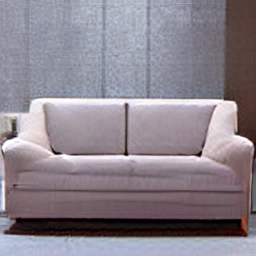

In [13]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))